In [2]:
%%capture
!pip install transformers

In [3]:
import pandas as pd
import os
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [6]:
os.chdir('drive/MyDrive/William_2022')

In [7]:
df = pd.read_csv('DATASETS/CSV/full_transcript_concat.csv')

In [16]:
df.nunique()

new_words         1850
seconds_trans      156
arousal_trans        4
valence_trans        3
happy_trans          3
angry_trans          3
nervous_trans        3
sad_trans            2
seconds2_trans     156
arousal2_trans       3
valence2_trans       4
happy2_trans         3
angry2_trans         2
nervous2_trans       3
sad2_trans           2
dtype: int64

In [8]:
df['arousal_trans'] = df['arousal_trans'].round()
df['arousal2_trans'] = df['arousal2_trans'].round()

df['valence_trans'] = df['valence_trans'].round()
df['valence2_trans'] = df['valence2_trans'].round()

df['happy_trans'] = df['happy_trans'].round()
df['happy2_trans'] = df['happy2_trans'].round()

df['angry_trans'] = df['angry_trans'].round()
df['angry2_trans'] = df['angry2_trans'].round()

df['nervous_trans'] = df['nervous_trans'].round()
df['nervous2_trans'] = df['nervous2_trans'].round()

df['sad_trans'] = df['sad_trans'].round()
df['sad2_trans'] = df['sad2_trans'].round()

In [9]:
df1 = df[['new_words', 'angry_trans']]

In [10]:
df1['angry_trans'] = df1['angry_trans'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
def to_emotion(rating):
  rating = int(rating)
  if rating == 2:
    return 'low'
  elif rating == 3:
    return 'high'
  else: 
    return 'very low'

df1['angry_trans'] = df.angry_trans.apply(to_emotion)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
df1

,new_words,happy_trans
0,all right first one the state for this accepti...,low
1,arrived in this especially in many Arab Jesus ...,low
2,Jeju Allah first of all I want to mention that...,very low
3,movement in South Korea against against this y...,very low
4,pretty much standard phobic activity because,very low
...,...,...
1858,The Courier what curse income,very low
1859,cannot there with this issue and cannot,very low
1860,change the no in this issue yeah,very low
1861,your suggestion is very proper but there's no ...,very low


In [18]:
df1['angry_trans'].value_counts()

very low    1491
low          370
high           2
Name: angry_trans, dtype: int64

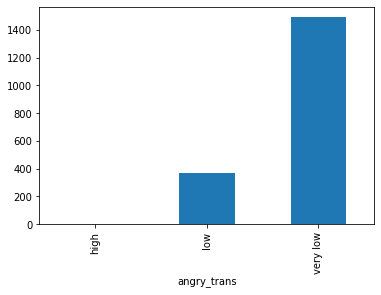

In [19]:
df1.groupby(['angry_trans']).size().plot.bar()

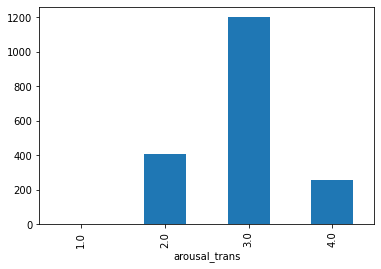

In [24]:
df. groupby(['arousal_trans']).size().plot.bar()

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {
    'very low' : 0,
    'low'      : 1,
    'high'     : 2
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['angry_trans']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['new_words']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:

np.random.seed(112)
df_train, df_val, df_test = np.split(df1.sample(frac=1, random_state=42), 
                                     [int(.8*len(df1)), int(.9*len(df1))])

print(len(df_train),len(df_val), len(df_test))

1490 186 187


In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 20
model = BertClassifier()
LR = 1e-4
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 745/745 [01:41<00:00,  7.37it/s]


Epochs: 1 | Train Loss:  0.407                 | Train Accuracy:  0.599                 | Val Loss:  0.376                 | Val Accuracy:  0.651


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 2 | Train Loss:  0.376                 | Train Accuracy:  0.601                 | Val Loss:  0.418                 | Val Accuracy:  0.565


100%|██████████| 745/745 [01:40<00:00,  7.39it/s]


Epochs: 3 | Train Loss:  0.380                 | Train Accuracy:  0.601                 | Val Loss:  0.440                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 4 | Train Loss:  0.371                 | Train Accuracy:  0.621                 | Val Loss:  0.402                 | Val Accuracy:  0.651


100%|██████████| 745/745 [01:43<00:00,  7.20it/s]


Epochs: 5 | Train Loss:  0.512                 | Train Accuracy:  0.650                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:42<00:00,  7.26it/s]


Epochs: 6 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.34it/s]


Epochs: 7 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.35it/s]


Epochs: 8 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.35it/s]


Epochs: 9 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.35it/s]


Epochs: 10 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.35it/s]


Epochs: 11 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.35it/s]


Epochs: 12 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.35it/s]


Epochs: 13 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.35it/s]


Epochs: 14 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 15 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 16 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 17 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 18 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 19 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 20 | Train Loss:  0.549                 | Train Accuracy:  0.658                 | Val Loss:  0.549                 | Val Accuracy:  0.645


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)


Test Accuracy:  0.701


In [ ]:
torch.save(model.state_dict(), 'happy_model.bin')

In [ ]:
def predict(model, text):
  text_dict = tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  if use_cuda:
    model = model.cuda()
    mask = text_dict['attention_mask'].to(device)
    input_id = text_dict['input_ids'].squeeze(1).to(device)
    
    with torch.no_grad():
      output = model(input_id, mask)
      label_id = output.argmax(dim=1).item()
      for key in labels.keys():
        if labels[key] == label_id:
          print(text, ' => ',key, '#' ,label_id)
          break

model.eval()
predict(model, text='I am extremely excited for the game')

I am extremely excited for the game  =>  very low # 0


In [ ]:
df2 = df[['new_words', 'happy2_trans']]

In [ ]:
df2['happy2_trans'] = df2['happy2_trans'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


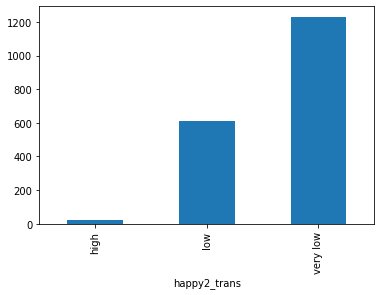

In [ ]:
df2.groupby(['happy2_trans']).size().plot.bar()

In [ ]:
def to_emotion(rating):
  rating = int(rating)
  if rating == 2:
    return 'low'
  elif rating == 3:
    return 'high'
  else: 
    return 'very low'

df2['happy2_trans'] = df.happy_trans.apply(to_emotion)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {
    'very low' : 0,
    'low'      : 1,
    'high'     : 2
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['happy2_trans']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['new_words']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:

np.random.seed(112)
df_train, df_val, df_test = np.split(df2.sample(frac=1, random_state=42), 
                                     [int(.8*len(df2)), int(.9*len(df2))])

print(len(df_train),len(df_val), len(df_test))

1490 186 187


In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 20
model = BertClassifier()
LR = 1e-4
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 745/745 [01:41<00:00,  7.35it/s]


Epochs: 1 | Train Loss:  0.394                 | Train Accuracy:  0.611                 | Val Loss:  0.409                 | Val Accuracy:  0.581


100%|██████████| 745/745 [01:41<00:00,  7.37it/s]


Epochs: 2 | Train Loss:  0.379                 | Train Accuracy:  0.607                 | Val Loss:  0.390                 | Val Accuracy:  0.581


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 3 | Train Loss:  0.377                 | Train Accuracy:  0.599                 | Val Loss:  0.412                 | Val Accuracy:  0.602


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 4 | Train Loss:  0.370                 | Train Accuracy:  0.626                 | Val Loss:  0.396                 | Val Accuracy:  0.565


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 5 | Train Loss:  0.375                 | Train Accuracy:  0.619                 | Val Loss:  0.382                 | Val Accuracy:  0.634


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 6 | Train Loss:  0.371                 | Train Accuracy:  0.623                 | Val Loss:  0.396                 | Val Accuracy:  0.581


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 7 | Train Loss:  0.366                 | Train Accuracy:  0.616                 | Val Loss:  0.396                 | Val Accuracy:  0.624


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 8 | Train Loss:  0.367                 | Train Accuracy:  0.626                 | Val Loss:  0.385                 | Val Accuracy:  0.618


100%|██████████| 745/745 [01:40<00:00,  7.39it/s]


Epochs: 9 | Train Loss:  0.366                 | Train Accuracy:  0.630                 | Val Loss:  0.392                 | Val Accuracy:  0.640


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 10 | Train Loss:  0.359                 | Train Accuracy:  0.632                 | Val Loss:  0.377                 | Val Accuracy:  0.656


100%|██████████| 745/745 [01:40<00:00,  7.38it/s]


Epochs: 11 | Train Loss:  0.358                 | Train Accuracy:  0.641                 | Val Loss:  0.385                 | Val Accuracy:  0.651


100%|██████████| 745/745 [01:42<00:00,  7.30it/s]


Epochs: 12 | Train Loss:  0.355                 | Train Accuracy:  0.648                 | Val Loss:  0.383                 | Val Accuracy:  0.640


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 13 | Train Loss:  0.358                 | Train Accuracy:  0.646                 | Val Loss:  0.381                 | Val Accuracy:  0.624


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 14 | Train Loss:  0.359                 | Train Accuracy:  0.654                 | Val Loss:  0.397                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 15 | Train Loss:  0.356                 | Train Accuracy:  0.652                 | Val Loss:  0.374                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 16 | Train Loss:  0.353                 | Train Accuracy:  0.656                 | Val Loss:  0.372                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 17 | Train Loss:  0.353                 | Train Accuracy:  0.654                 | Val Loss:  0.374                 | Val Accuracy:  0.651


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 18 | Train Loss:  0.352                 | Train Accuracy:  0.656                 | Val Loss:  0.403                 | Val Accuracy:  0.468


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 19 | Train Loss:  0.351                 | Train Accuracy:  0.654                 | Val Loss:  0.378                 | Val Accuracy:  0.645


100%|██████████| 745/745 [01:41<00:00,  7.36it/s]


Epochs: 20 | Train Loss:  0.354                 | Train Accuracy:  0.657                 | Val Loss:  0.384                 | Val Accuracy:  0.645


In [ ]:
torch.save(model.state_dict(), 'happy2_model.bin')

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)


Test Accuracy:  0.701


In [ ]:
model = BertClassifier()
model.load_state_dict(torch.load('happy2_model.bin'))
model.eval()

In [ ]:
def predict(model, text):
  text_dict = tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  if use_cuda:
    model = model.cuda()
    mask = text_dict['attention_mask'].to(device)
    input_id = text_dict['input_ids'].squeeze(1).to(device)
    
    with torch.no_grad():
      output = model(input_id, mask)
      label_id = output.argmax(dim=1).item()
      for key in labels.keys():
        if labels[key] == label_id:
          print(text, ' => ',key, '#' ,label_id)
          break

model.eval()
predict(model, text='I am SOOO EXCITED')

I am SOOO EXCITED  =>  very low # 0


In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])